In [1]:
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# Load the files
scene = "individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels"
date = "202504141722"

# filepath of the csv file with the scene poses_data
landmarks_file_path = os.path.join(os.getcwd(), scene + "/" + date, "landmarks_" + scene + ".csv")
landmarks_candidates_file_path = os.path.join(os.getcwd(), scene + "/" + date, "landmarks_candidates_" + scene + ".csv")
print("Landmarks File Path:", landmarks_file_path)
print("Landmarks Candidates File Path:", landmarks_candidates_file_path)

Landmarks File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels/202504141722/landmarks_individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels.csv
Landmarks Candidates File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels/202504141722/landmarks_candidates_individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels.csv


In [3]:
# Filepath of the signs map features csv file
signs_map_features_file_path = os.path.join(
    os.path.dirname((os.getcwd())),
    "pointcloud_clustering/map",
    "signs_map_features_" + scene + ".csv"
)
print("Signs Map Features File Path:", signs_map_features_file_path)

Signs Map Features File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/pointcloud_clustering/map/signs_map_features_individual_files_validation_segment-10335539493577748957_1372_870_1392_870_with_camera_labels.csv


In [4]:
# Load the CSV files into pandas DataFrames
landmarks_df = pd.read_csv(landmarks_file_path)
landmarks_candidates_df = pd.read_csv(landmarks_candidates_file_path)
signs_map_features_df = pd.read_csv(signs_map_features_file_path, header=None)

In [5]:
landmarks_df

,frame,match_index,Landmark_X,Landmark_Y,Landmark_Z,Landmark_Roll,Landmark_Pitch,Landmark_Yaw
0,[6],[-1],68.198053,-7.572438,0.449174,-0.002683,0.001033,-0.000889
1,[7],[4],62.088548,-6.241956,0.393810,-0.002778,0.000058,-0.001536
2,[9],[4],65.567033,-5.129073,0.325689,-0.002775,0.001752,-0.002825
3,[9],[4],62.063527,-6.267329,0.480944,-0.002775,0.001752,-0.002825
4,[10],[4],65.569966,-5.159370,0.303944,-0.001816,0.003372,-0.003249
...,...,...,...,...,...,...,...,...
126,[167],[-1],353.916151,-11.343645,0.539195,0.005290,0.008493,-0.009418
127,[167],[-1],366.011846,-12.371438,0.266622,0.005290,0.008493,-0.009418
128,[168],[-1],336.708038,-13.518707,1.614792,0.003946,0.008512,-0.008651
129,[168],[-1],355.340378,-11.324634,0.537930,0.003946,0.008512,-0.008651


In [6]:
landmarks_candidates_df

,frame,match_index,Landmark_X,Landmark_Y,Landmark_Z,Landmark_Roll,Landmark_Pitch,Landmark_Yaw
0,[1],[0],-15.761840,3.287186,0.089966,0.000000,-0.000000,0.000000
1,[1],[0],21.014865,-32.487118,0.805725,0.000000,-0.000000,0.000000
2,[1],[0],28.080164,24.781325,-0.290833,0.000000,-0.000000,0.000000
3,[1],[0],14.908093,24.930906,-0.365967,0.000000,-0.000000,0.000000
4,[1],[0],-5.055397,-30.436937,0.542786,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...
4562,[168],[-1],336.036307,25.010132,-0.705699,0.003946,0.008512,-0.008651
4563,[168],[-1],325.898410,-14.576816,1.505399,0.003946,0.008512,-0.008651
4564,[168],[-1],330.259379,32.030260,1.103020,0.003946,0.008512,-0.008651
4565,[168],[-1],272.588259,34.472987,-1.179161,0.003946,0.008512,-0.008651


In [7]:
# Add headers to the signs_map_features_df
signs_map_features_df.columns = ['Landmark_X', 'Landmark_Y', 'Landmark_Z']

In [8]:
signs_map_features_df

,Landmark_X,Landmark_Y,Landmark_Z
0,24.104259,18.388585,-0.216689
1,94.930172,18.700377,-0.384808
2,99.624343,-6.180990,0.187112
3,65.578178,-5.367456,0.106284
4,62.204167,-6.323775,0.330217
...,...,...,...
128,377.314457,23.938979,-0.316044
129,377.509098,23.844535,-0.324447
130,377.187129,26.766616,-0.339168
131,377.169753,26.940456,0.291829


In [9]:
frame = 1
frame = '['+str(frame)+']'
filtered_landmarks_df = landmarks_df[landmarks_df['frame'] == frame]
filtered_landmarks_df

,frame,match_index,Landmark_X,Landmark_Y,Landmark_Z,Landmark_Roll,Landmark_Pitch,Landmark_Yaw


In [10]:
filtered_landmarks_candidates_df = landmarks_candidates_df[landmarks_candidates_df['frame'] == frame]
filtered_landmarks_candidates_df

,frame,match_index,Landmark_X,Landmark_Y,Landmark_Z,Landmark_Roll,Landmark_Pitch,Landmark_Yaw
0,[1],[0],-15.761840,3.287186,0.089966,0.0,-0.0,0.0
1,[1],[0],21.014865,-32.487118,0.805725,0.0,-0.0,0.0
2,[1],[0],28.080164,24.781325,-0.290833,0.0,-0.0,0.0
3,[1],[0],14.908093,24.930906,-0.365967,0.0,-0.0,0.0
4,[1],[0],-5.055397,-30.436937,0.542786,0.0,-0.0,0.0
5,[1],[0],-32.508735,-22.907949,2.617065,0.0,-0.0,0.0
6,[1],[0],57.983324,27.667877,1.834534,0.0,-0.0,0.0
7,[1],[0],20.965739,-20.309364,1.173401,0.0,-0.0,0.0
8,[1],[0],-15.685736,-22.417439,1.734436,0.0,-0.0,0.0
9,[1],[0],32.950436,0.428829,0.025940,0.0,-0.0,0.0


In [11]:
def calculate_center_and_max_radius(landmarks_df):
    """
    Calcula el centro en X e Y y el radio máximo de los landmarks.

    Parameters:
        landmarks_df (pd.DataFrame): DataFrame que contiene las columnas 'Landmark_X' y 'Landmark_Y'.

    Returns:
        tuple: Una tupla con el centro en X, el centro en Y y el radio máximo.
    """
    if landmarks_df.empty:
        return None, None, None

    center_x = landmarks_df['Landmark_X'].mean()
    center_y = landmarks_df['Landmark_Y'].mean()

    # Calcular el radio máximo como la distancia máxima desde el centro
    distances = ((landmarks_df['Landmark_X'] - center_x)**2 + (landmarks_df['Landmark_Y'] - center_y)**2)**0.5
    max_radius = distances.max()

    return center_x, center_y, max_radius

In [12]:
center_x, center_y, max_radius = calculate_center_and_max_radius(filtered_landmarks_candidates_df)
print(f"Centro en X: {center_x}, Centro en Y: {center_y}, Radio máximo: {max_radius}")

max_radius = max_radius + 10

Centro en X: 6.611781962488456, Centro en Y: 2.1504811778914887, Radio máximo: 73.12672623001157


In [13]:
filtered_signs_map_features_df = signs_map_features_df[
        ((signs_map_features_df['Landmark_X'] - center_x)**2 + 
        (signs_map_features_df['Landmark_Y'] - center_y)**2)**0.5 <= max_radius
]

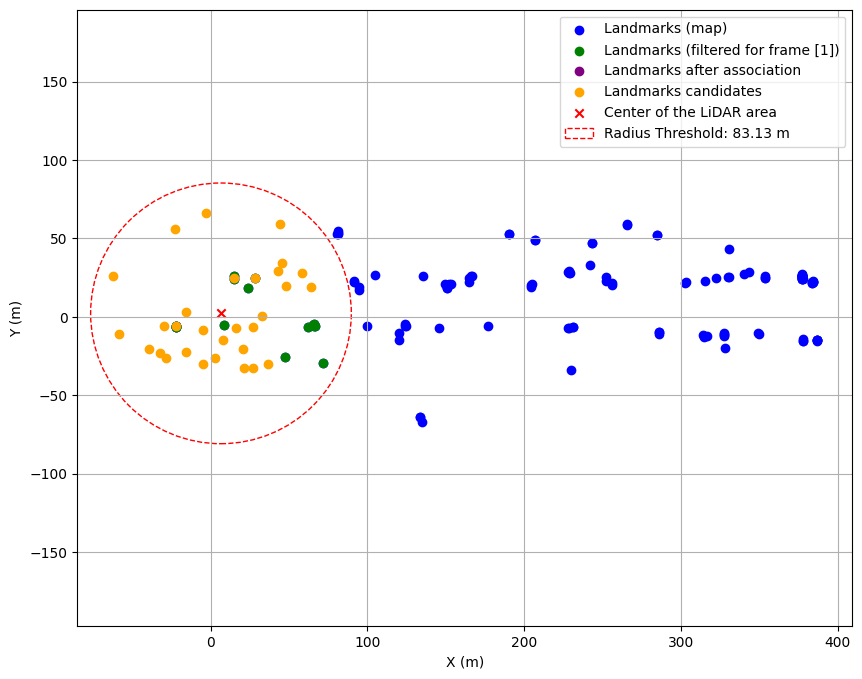

In [14]:
# Draw the circle
circle = plt.Circle((center_x, center_y), max_radius, color='red', fill=False, linestyle='--', label=f'Radius Threshold: {max_radius:.2f} m')

# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(signs_map_features_df['Landmark_X'], signs_map_features_df['Landmark_Y'], color='blue', label='Landmarks (map)')
plt.scatter(filtered_signs_map_features_df['Landmark_X'], filtered_signs_map_features_df['Landmark_Y'], color='green', label=f'Landmarks (filtered for frame {frame})')
plt.scatter(filtered_landmarks_df['Landmark_X'], filtered_landmarks_df['Landmark_Y'], color='purple', label='Landmarks after association')
plt.scatter(filtered_landmarks_candidates_df['Landmark_X'], filtered_landmarks_candidates_df['Landmark_Y'], color='orange', label='Landmarks candidates')
plt.scatter(center_x, center_y, color='red', label='Center of the LiDAR area', marker='x')

# Add the circle to the plot
plt.gca().add_artist(circle)

# Add labels, legend, and grid
plt.legend()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid()

# Set equal scaling for axes
plt.axis('equal')

plt.show()

In [15]:
import scipy.spatial

# Función para evaluar los matches
def evaluate_matches(globalmapdata, evalmapdata):
    n = globalmapdata['poleparams'].shape[0]
    evalpolemap = evalmapdata['polemeans'][:, :2]
    n_eval = evalpolemap.shape[0]
    maxdist = 1.0
    kdtree = scipy.spatial.cKDTree(globalmapdata['poleparams'][:, :2], leafsize=10)
    dist, _ = kdtree.query(evalpolemap, k=1, distance_upper_bound=maxdist)
    n_matches = np.sum(np.isfinite(dist))

    matched_param = evalpolemap[np.isfinite(dist), :]
    TP = n_matches
    FP = n_eval - n_matches
    FN = n - n_matches
    precision = (TP + 0.0) / (TP + FP)
    recall = (TP + 0.0) / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)

    # Return matched_params as a dictionary
    matched_params = {
        'matched_coordinates': matched_param,
        'n_matches': n_matches,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'precision': precision,
        'recall': recall,
        'F1': F1
    }
    return matched_params

In [16]:
def evaluate_frame(frame, landmarks_df, signs_map_df):
    """
    Evaluates matches for a specific frame.

    Parameters:
        frame (int): The frame number to evaluate.
        landmarks_df (pd.DataFrame): DataFrame containing landmarks data.
        signs_map_df (pd.DataFrame): DataFrame containing signs map features.

    Returns:
        dict: A dictionary containing matched parameters and evaluation metrics.
    """
    frame_candidates_df = landmarks_df[landmarks_df['frame'] == frame]

    # Calculate center and radius
    center_x, center_y, max_radius = calculate_center_and_max_radius(frame_candidates_df)
    if center_x is None or center_y is None or max_radius is None:
        return None

    # Filter signs map features using the center and radius
    filtered_signs_map = signs_map_df[
        ((signs_map_df['Landmark_X'] - center_x)**2 + 
         (signs_map_df['Landmark_Y'] - center_y)**2)**0.5 <= max_radius
    ]

    # Prepare data for evaluate_matches
    globalmapdata = {'poleparams': filtered_signs_map[['Landmark_X', 'Landmark_Y']].to_numpy()}
    evalmapdata = {'polemeans': frame_candidates_df[['Landmark_X', 'Landmark_Y']].to_numpy()}

    # Evaluate matches
    matched_params = evaluate_matches(globalmapdata, evalmapdata)

    return matched_params

In [17]:
# Evaluate a single frame
clustering_frame_results = evaluate_frame('[1]', landmarks_candidates_df, signs_map_features_df)
pprint.pprint(clustering_frame_results)

{'F1': 0.13043478260869568,
 'FN': 13,
 'FP': 27,
 'TP': 3,
 'matched_coordinates': array([[ 28.08016398,  24.78132512],
       [ 14.90809337,  24.93090596],
       [-21.77522086,  -6.12003958]]),
 'n_matches': 3,
 'precision': 0.1,
 'recall': 0.1875}


In [18]:
# Evaluate all frames
unique_frames = landmarks_candidates_df['frame'].unique()

results_clustering = []
results_association = []
for frame in unique_frames:
    results_clustering.append({'frame': frame, 'matched_params': evaluate_frame(frame, landmarks_candidates_df, signs_map_features_df)})
    results_association.append({'frame': frame, 'matched_params': evaluate_frame(frame, landmarks_df, signs_map_features_df)})

/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:19: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = (TP + 0.0) / (TP + FN)
/tmp/ipykernel_30144/3221835485.py:18: RuntimeWarning: in

In [19]:
# Create a DataFrame from the association results
results_association_df = pd.DataFrame(results_association)

# Expand the 'matched_params' column into separate columns, handling None values
results_association_df['matched_params'] = results_association_df['matched_params'].apply(lambda x: {} if x is None else x)
expanded_columns = results_association_df['matched_params'].apply(pd.Series)

# Concatenate the expanded columns with the original DataFrame
results_association_df = pd.concat([results_association_df.drop(columns=['matched_params']), expanded_columns], axis=1)

# Display the expanded DataFrame
results_association_df

/tmp/ipykernel_30144/3342679070.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_columns = results_association_df['matched_params'].apply(pd.Series)
/tmp/ipykernel_30144/3342679070.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_columns = results_association_df['matched_params'].apply(pd.Series)
/tmp/ipykernel_30144/3342679070.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  expanded_columns = results_association_df['matched_params'].apply(pd.Series)
/tmp/ipykernel_30144/3342679070.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype exp

,frame,matched_coordinates,n_matches,TP,FP,FN,precision,recall,F1
0,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[4],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
163,[164],"[[349.5489899731848, -11.40635703420152]]",1.0,1.0,2.0,1.0,0.333333,0.5,0.4
164,[165],[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN
165,[166],[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN
166,[167],[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN


In [20]:
# Create a DataFrame from the association results
results_clustering_df = pd.DataFrame(results_clustering)

# Expand the 'matched_params' column into separate columns, handling None values
results_clustering_df['matched_params'] = results_clustering_df['matched_params'].apply(lambda x: {} if x is None else x)
expanded_columns = results_clustering_df['matched_params'].apply(pd.Series)

# Concatenate the expanded columns with the original DataFrame
results_clustering_df = pd.concat([results_clustering_df.drop(columns=['matched_params']), expanded_columns], axis=1)

# Display the expanded DataFrame
results_clustering_df

,frame,matched_coordinates,n_matches,TP,FP,FN,precision,recall,F1
0,[1],"[[28.08016397664835, 24.781325120192307], [14....",3,3,27,13,0.100000,0.187500,0.130435
1,[2],"[[-21.774003705337016, -6.1283514277171225], [...",2,2,21,13,0.086957,0.133333,0.105263
2,[3],"[[14.891993657249326, 24.83919545207824]]",1,1,29,15,0.033333,0.062500,0.043478
3,[4],"[[28.08537347712587, 24.754715797644927], [62....",3,3,29,13,0.093750,0.187500,0.125000
4,[5],"[[28.060032804426584, 24.778726792123138], [-2...",3,3,31,12,0.088235,0.200000,0.122449
...,...,...,...,...,...,...,...,...,...
163,[164],"[[353.91934186567363, 25.462271224443302], [34...",6,6,23,26,0.206897,0.187500,0.196721
164,[165],"[[315.7047137833571, -11.841557134914597]]",1,1,28,31,0.034483,0.031250,0.032787
165,[166],"[[314.774324322922, 22.23796830051658]]",1,1,28,51,0.034483,0.019231,0.024691
166,[167],"[[316.1856293947568, 22.225129622631822]]",1,1,28,51,0.034483,0.019231,0.024691


In [21]:
# Merge clustering and association results on the 'frame' column
merged_results_df = pd.merge(
    results_clustering_df,
    results_association_df,
    on='frame',
    suffixes=('_clustering', '_association')
)

# Display the merged DataFrame
merged_results_df

,frame,matched_coordinates_clustering,n_matches_clustering,TP_clustering,FP_clustering,FN_clustering,precision_clustering,recall_clustering,F1_clustering,matched_coordinates_association,n_matches_association,TP_association,FP_association,FN_association,precision_association,recall_association,F1_association
0,[1],"[[28.08016397664835, 24.781325120192307], [14....",3,3,27,13,0.100000,0.187500,0.130435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[2],"[[-21.774003705337016, -6.1283514277171225], [...",2,2,21,13,0.086957,0.133333,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[3],"[[14.891993657249326, 24.83919545207824]]",1,1,29,15,0.033333,0.062500,0.043478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[4],"[[28.08537347712587, 24.754715797644927], [62....",3,3,29,13,0.093750,0.187500,0.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[5],"[[28.060032804426584, 24.778726792123138], [-2...",3,3,31,12,0.088235,0.200000,0.122449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,[164],"[[353.91934186567363, 25.462271224443302], [34...",6,6,23,26,0.206897,0.187500,0.196721,"[[349.5489899731848, -11.40635703420152]]",1.0,1.0,2.0,1.0,0.333333,0.5,0.4
164,[165],"[[315.7047137833571, -11.841557134914597]]",1,1,28,31,0.034483,0.031250,0.032787,[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN
165,[166],"[[314.774324322922, 22.23796830051658]]",1,1,28,51,0.034483,0.019231,0.024691,[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN
166,[167],"[[316.1856293947568, 22.225129622631822]]",1,1,28,51,0.034483,0.019231,0.024691,[],0.0,0.0,3.0,2.0,0.000000,0.0,NaN


In [22]:
print("CLUSTERING RESULTS")

# Aggregate the results for the entire scene
total_clustering_TP = results_clustering_df['TP'].sum()
total_clustering_FP = results_clustering_df['FP'].sum()
total_clustering_FN = results_clustering_df['FN'].sum()

# Calculate overall precision, recall, and F1 score
overall_clustering_precision = total_clustering_TP / (total_clustering_TP + total_clustering_FP) if (total_clustering_TP + total_clustering_FP) > 0 else 0
overall_clustering_recall = total_clustering_TP / (total_clustering_TP + total_clustering_FN) if (total_clustering_TP + total_clustering_FN) > 0 else 0
overall_clustering_F1 = 2 * overall_clustering_precision * overall_clustering_recall / (overall_clustering_precision + overall_clustering_recall) if (overall_clustering_precision + overall_clustering_recall) > 0 else 0

print(f"Overall Precision: {overall_clustering_precision:.4f}")
print(f"Overall Recall: {overall_clustering_recall:.4f}")
print(f"Overall F1 Score: {overall_clustering_F1:.4f}")

CLUSTERING RESULTS
Overall Precision: 0.0966
Overall Recall: 0.0802
Overall F1 Score: 0.0876


In [23]:
print("ASSOCIATION RESULTS")
# Aggregate the results for the entire scene
total_association_TP = results_association_df['TP'].sum()
total_association_FP = results_association_df['FP'].sum()
total_association_FN = results_association_df['FN'].sum()
# Calculate overall precision, recall, and F1 score
overall_association_precision = total_association_TP / (total_association_TP + total_association_FP) if (total_association_TP + total_association_FP) > 0 else 0
overall_association_recall = total_association_TP / (total_association_TP + total_association_FN) if (total_association_TP + total_association_FN) > 0 else 0
overall_association_F1 = 2 * overall_association_precision * overall_association_recall / (overall_association_precision + overall_association_recall) if (overall_association_precision + overall_association_recall) > 0 else 0
print(f"Overall Precision:  {overall_association_precision:.4f}")
print(f"Overall Recall:     {overall_association_recall:.4f}")
print(f"Overall F1 Score:   {overall_association_F1:.4f}")

ASSOCIATION RESULTS
Overall Precision:  0.2290
Overall Recall:     0.3571
Overall F1 Score:   0.2791


In [24]:
# Create a summary table
summary_data = {
    'Metric': ['Total TP', 'Total FP', 'Total FN', 'Overall Precision', 'Overall Recall', 'Overall F1 Score'],
    'Clustering': [
        total_clustering_TP,
        total_clustering_FP,
        total_clustering_FN,
        overall_clustering_precision,
        overall_clustering_recall,
        overall_clustering_F1
    ],
    'Association': [
        total_association_TP,
        total_association_FP,
        total_association_FN,
        overall_association_precision,
        overall_association_recall,
        overall_association_F1
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary table
summary_df

,Metric,Clustering,Association
0,Total TP,441.000000,30.000000
1,Total FP,4126.000000,101.000000
2,Total FN,5058.000000,54.000000
3,Overall Precision,0.096562,0.229008
4,Overall Recall,0.080196,0.357143
5,Overall F1 Score,0.087622,0.279070
